# Lay of Land - Spook Author Identification

Lets' start by getting a lay of land using a code first approach. Idea is to quickly jump into training NLP models using clean datasets from Kaggle. I am going to follow [this wonderful kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) from Abhishek Thakur,a prolific Kaggle GM, for [Spooky Author Classification Competition](https://www.kaggle.com/c/spooky-author-identification/overview).


```{note}
Whenever we start a kaggle competition it is useful to look at evaluation metric first. Real life project are not like Kaggle. In real world following activities happen before 
- Identify a business problem 
- Clarify and refine the problem and convert the same into ML problem. 
- Collect relevant datasets
- Preprocess and clean the dataset
- Define an evaluation metric relevant for value proposition


However, when we are learning it might be useful to start with a clean dataset with evaluation criteria defined; so that we can concentrate on learning modelling skills
```

## Imports

It is better to keep all imports at the top of notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics, pipeline
from fastai.basics import *
from nlphero.data.external import *


In [2]:
%matplotlib inline

In [3]:
data = untar_data(KAGGLEs.SPOOKY)

In [4]:
data.ls()

(#3) [Path('/Landmark2/pdo/.nlphero/data/spooky/train.csv'),Path('/Landmark2/pdo/.nlphero/data/spooky/test.csv'),Path('/Landmark2/pdo/.nlphero/data/spooky/sample_submission.csv')]

## Simple EDA

First we should check out the data

In [5]:
train = pd.read_csv(data/"train.csv")
test = pd.read_csv(data/"test.csv")
sample = pd.read_csv(data/"sample_submission.csv")
train.head()
#test.head()
#sample.head()

id  \
0  id26305   
1  id17569   
2  id11008   
3  id27763   
4  id12958   

                                                                                                                                                                                                                                      text  \
0  This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.   
1                                                                                                                                                                  It never once occurred to me that the fumbling might be a mere mistake.   
2                                 In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.   
3                           How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.   
4                                                           Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.   

  author  
0    EAP  
1    HPL  
2    EAP  
3    MWS  
4    HPL

<AxesSubplot:>

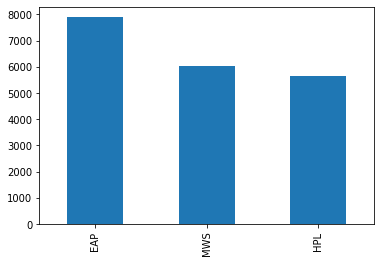

In [6]:
train['author'].value_counts().plot(kind='bar')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8392 non-null   object
 1   text    8392 non-null   object
dtypes: object(2)
memory usage: 131.2+ KB


In [9]:
sample.head()
# print("HHH")

id       EAP       HPL       MWS
0  id02310  0.403494  0.287808  0.308698
1  id24541  0.403494  0.287808  0.308698
2  id00134  0.403494  0.287808  0.308698
3  id27757  0.403494  0.287808  0.308698
4  id04081  0.403494  0.287808  0.308698

So we have roughly 20k rows and about 8.4K test data (41% of size of train data). Classes are more or less equally distributed. We need to predict probabilities of different authors.

## Evaluation Metric

For this competition, kaggle has defined multi class log loss as evaluation metric defined in link [here](https://www.kaggle.com/c/spooky-author-identification/overview/evaluation). What does it mean ?
- For each id ; we must predict probability of each author
- Formulae for evaluation is defined as 

\begin{align}
L &= Logloss = -\frac{1}{N} \Sigma_{i=1}^{N} \Sigma_{j=1}^{M}{y_{ij}}{\log{p_{ij}}}\\
N &= Samples\\
M &= PredictionClasses\\
y_{ij} &= \left\{ \begin{array}{rcl}
1 & if &Observation(i) \in Class(j) \\ 0 & otherwise\\
\end{array}\right.\\
p_{ij} &= PredictedProbability [Observation(i) \in Class(j)] &
{where} &&
\Sigma p_{ij} &= 1 \\
Num[p_{ij}] &= max(min(p_{ij}, 1- 10^{-15}), 10^{-15}) &
{where} &&
\Sigma Num[p_{ij}] & \neq 1 \\
\end{align}


In [10]:

10**(-15)

1e-15

In [11]:
actual = np.random.randint(3, size=10)
print(actual.shape)
actual

(10,)


array([1, 2, 0, 2, 1, 1, 2, 2, 2, 0])

In [12]:
# Assume 10 samples and 3 classes[probabilities]
a = np.random.randint(1, 100, size=(10,3))
b = a.sum(axis=1).reshape(-1,1)
predicted = np.round(a/b,2)
predicted

array([[0.38, 0.09, 0.53],
       [0.16, 0.31, 0.54],
       [0.34, 0.31, 0.35],
       [0.24, 0.7 , 0.06],
       [0.65, 0.22, 0.13],
       [0.4 , 0.41, 0.19],
       [0.35, 0.24, 0.42],
       [0.24, 0.42, 0.34],
       [0.27, 0.34, 0.39],
       [0.2 , 0.08, 0.72]])

In [13]:
len(actual.shape)

1

In [14]:
actual2 = np.zeros((actual.shape[0],predicted.shape[1]))
actual2[actual.reshape(-1,1)] = 0

for i, val in enumerate(actual):
#     print(i,val)
    actual2[i, val]=1
actual2

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [15]:
def convert_multiclass(actual):
    actual2 = np.zeros((actual.shape[0],predicted.shape[1]))
    actual2[actual.reshape(-1,1)] = 0
    for i, val in enumerate(actual):
        actual2[i, val]=1
    return actual2

In [16]:
eps = 10**-15
y_ij = convert_multiclass(actual)
N = len(actual)
num_pij = np.clip(predicted, eps, 1-eps)
L = -(y_ij*np.log(num_pij)).sum()/N
L

1.3819434659490413

In [17]:
def multiclass_logloss(actual, predicted, eps=10**-15):
    y_ij = convert_multiclass(actual)
    N = len(actual)
    num_pij = np.clip(predicted, eps, 1-eps)
    L = -(y_ij*np.log(num_pij)).sum()/N
    return L

## Train Test Split

We split and stratify based on output

In [18]:
x_train, y_train = train[['id','text']], train['author']
lbl_encoder = LabelEncoder()
y_train = lbl_encoder.fit_transform(y_train)

In [19]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, stratify=y_train, test_size=0.33, random_state=42)
len(x_train), len(x_valid)

(13117, 6462)

## Modelling

### TF-IDF with Logistic Regression

[Term frequency inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

A good reference can be found [here](https://www.onely.com/blog/what-is-tf-idf/)

- {$TF \to  \text{Frequency of term in a document} $} indicates if you are using the word too many time in a document or too little.

- {$IDF \to \text{Inverse document Frequency}$} of a word is the measure of how significant that term is in the whole corpus.

- $ TF.IDF(t, d)=W_t^{d} = TF_t^{d}\ln{\frac{N}{DF^t}}$
  - $N=\text{Total number of documents}$
  - $DF^t=\text{Number of document with term t}$ 
  
- Put simply, the higher the TF.IDF score (weight), the rarer the term and vice versa.

In [20]:
tfv = TfidfVectorizer(min_df=1,
                      max_features=None,
                      strip_accents="unicode",
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1,3),
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words='english'
                     )
tfv

TfidfVectorizer(ngram_range=(1, 3), smooth_idf=1, stop_words='english',
                strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [21]:
tfv.fit(np.concatenate([x_train['text'].values,x_valid['text'].values]))

TfidfVectorizer(ngram_range=(1, 3), smooth_idf=1, stop_words='english',
                strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [22]:
x_train_tfv = tfv.transform(x_train['text'].values)
x_train_tfv

<13117x400219 sparse matrix of type '<class 'numpy.float64'>'
	with 413765 stored elements in Compressed Sparse Row format>

In [23]:
x_valid_tfv = tfv.transform(x_valid['text'].values)
x_valid_tfv

<6462x400219 sparse matrix of type '<class 'numpy.float64'>'
	with 205383 stored elements in Compressed Sparse Row format>

In [24]:
clf = LogisticRegression(C=1.0)
clf.fit(x_train_tfv, y_train)

LogisticRegression()

In [25]:
val_preds = clf.predict_proba(x_valid_tfv)
val_preds

array([[0.41254593, 0.26687746, 0.32057661],
       [0.26133285, 0.13761174, 0.60105541],
       [0.29159974, 0.4086124 , 0.29978786],
       ...,
       [0.60269293, 0.18377996, 0.21352711],
       [0.20320163, 0.16185855, 0.63493981],
       [0.56495872, 0.15974122, 0.27530006]])

In [26]:
print ("logloss: %0.3f " % multiclass_logloss(y_valid, val_preds))

logloss: 0.806 


In [27]:
def multiclass_logloss2(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [28]:
print ("logloss: %0.3f " % multiclass_logloss2(y_valid, val_preds))

logloss: 0.806 


### CountVector with Logistic Regression

CountVectorizer - Frequency of different words

In [29]:
cv = CountVectorizer(analyzer='word',
                     token_pattern=r'\w{1,}',
                     ngram_range=(1,3),
                     stop_words='english'
                    )
cv

CountVectorizer(ngram_range=(1, 3), stop_words='english',
                token_pattern='\\w{1,}')

In [30]:
cv.fit(np.concatenate([x_train['text'].values,x_valid['text'].values]))

CountVectorizer(ngram_range=(1, 3), stop_words='english',
                token_pattern='\\w{1,}')

In [31]:
x_train_cv = cv.transform(x_train['text'].values)
x_train_cv

<13117x400266 sparse matrix of type '<class 'numpy.int64'>'
	with 413776 stored elements in Compressed Sparse Row format>

In [32]:
x_valid_cv = cv.transform(x_valid['text'].values)
x_valid_cv

<6462x400266 sparse matrix of type '<class 'numpy.int64'>'
	with 205395 stored elements in Compressed Sparse Row format>

In [33]:
clf = LogisticRegression(C=1.0)
clf.fit(x_train_cv, y_train)
clf

LogisticRegression()

In [34]:
val_preds = clf.predict_proba(x_valid_cv)
val_preds

array([[0.53572102, 0.11567325, 0.34860574],
       [0.03049094, 0.00427   , 0.96523906],
       [0.33594102, 0.3222241 , 0.34183488],
       ...,
       [0.97113843, 0.01189312, 0.01696845],
       [0.05768433, 0.02785335, 0.91446231],
       [0.8622879 , 0.020955  , 0.1167571 ]])

In [35]:
print ("logloss: %0.3f " % multiclass_logloss2(y_valid, val_preds))

logloss: 0.557 


### MultinomialNB

In [36]:
clf = MultinomialNB()
clf.fit(x_train_tfv, y_train)

MultinomialNB()

In [37]:
val_preds = clf.predict_proba(x_valid_tfv)
val_preds

array([[0.43479056, 0.2630958 , 0.30211364],
       [0.33038311, 0.16973709, 0.4998798 ],
       [0.37577295, 0.34463046, 0.27959659],
       ...,
       [0.54395868, 0.18701702, 0.2690243 ],
       [0.27495975, 0.18696675, 0.5380735 ],
       [0.56420466, 0.16682221, 0.26897313]])

In [38]:
print ("logloss: %0.3f " % multiclass_logloss(y_valid, val_preds))

logloss: 0.853 


In [39]:
clf = MultinomialNB()
clf.fit(x_train_cv, y_train)
val_preds = clf.predict_proba(x_valid_cv)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, val_preds))

logloss: 0.467 


In [40]:
def check_score(clf, vectorizer, 
                x_train=x_train, x_valid=x_valid,
                y_train=y_train, y_valid=y_valid):
    
    vectorizer.fit(np.concatenate([x_train['text'].values,
                                   x_valid['text'].values]))
    x_train_vect = vectorizer.transform(x_train['text'].values)
    x_valid_vect = vectorizer.transform(x_valid['text'].values)
    clf.fit(x_train_vect, y_train)
    val_preds = clf.predict_proba(x_valid_vect)
    mcll = multiclass_logloss(y_valid, val_preds)
    return mcll

In [41]:
clf = MultinomialNB()
vectorizer = CountVectorizer(analyzer='word',
                     token_pattern=r'\w{1,}',
                     ngram_range=(1,3),
                     stop_words='english'
                    )
score = check_score(clf, vectorizer)
print ("logloss: %0.3f " % score)

logloss: 0.467 


In [42]:
score = check_score(clf, tfv)
print ("logloss: %0.3f " % score)

logloss: 0.853 


### SVD

In [43]:
svd = TruncatedSVD(n_components=120)

In [44]:
svd.fit(x_train_cv)

TruncatedSVD(n_components=120)

In [45]:
xtrain_svd = svd.transform(x_train_cv)
xvalid_svd = svd.transform(x_valid_cv)

In [46]:
scl = StandardScaler()
scl.fit(xtrain_svd)

StandardScaler()

In [47]:
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

In [48]:
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, y_train)
val_preds = clf.predict_proba(xvalid_svd_scl)

In [49]:
print("logloss: %0.3f " % multiclass_logloss(y_valid, val_preds))

logloss: 0.787 


In [50]:
x_train_tfv.tocsc()

<13117x400219 sparse matrix of type '<class 'numpy.float64'>'
	with 413765 stored elements in Compressed Sparse Column format>

In [51]:
x_train_tfv

<13117x400219 sparse matrix of type '<class 'numpy.float64'>'
	with 413765 stored elements in Compressed Sparse Row format>

### XGBoost

#### CountVectorizer

In [52]:
clf = xgb.XGBClassifier(max_depth=7, 
                        n_estimators=200, 
                        colsample_bytree=0.8, 
                        subsample=0.8, 
                        nthread=10, 
                        learning_rate=0.1)
vectorizer = CountVectorizer(analyzer='word',
                     token_pattern=r'\w{1,}',
                     ngram_range=(1,3),
                     stop_words='english'
                    )
score = check_score(clf, vectorizer)
print ("logloss: %0.3f " % score)

logloss: 0.776 


#### Tf-idfVectorizer

In [53]:
clf = xgb.XGBClassifier(max_depth=7, 
                        n_estimators=200, 
                        colsample_bytree=0.8, 
                        subsample=0.8, 
                        nthread=10, 
                        learning_rate=0.1)

vectorizer = TfidfVectorizer(min_df=1,
                      max_features=None,
                      strip_accents="unicode",
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1,3),
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words='english'
                     )
score = check_score(clf, vectorizer)
print ("logloss: %0.3f " % score)

logloss: 0.787 


#### SVD Transformation

In [54]:
clf = xgb.XGBClassifier(max_depth=7, 
                        n_estimators=200, 
                        colsample_bytree=0.8, 
                        subsample=0.8, 
                        nthread=10, 
                        learning_rate=0.1)
clf.fit(xtrain_svd, y_train)
val_preds = clf.predict_proba(xvalid_svd)
score = multiclass_logloss(y_valid, val_preds)
print ("logloss: %0.3f " % score)

logloss: 0.805 


## Grid Search

Doing Grid Search using Logistic Regression

In [55]:
# mll_scorer = metrics.make_scorer?

In [56]:
mll_scorer = metrics.make_scorer(multiclass_logloss, 
                                greater_is_better=False,
                                needs_proba=True)

In [57]:
mll_scorer

make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)

In [58]:
svd = TruncatedSVD()
scl = StandardScaler()
lr_model = LogisticRegression()

clf = pipeline.Pipeline([
    ('svd', svd),
    ('scl', scl),
    ('lr', lr_model)
])
clf

Pipeline(steps=[('svd', TruncatedSVD()), ('scl', StandardScaler()),
                ('lr', LogisticRegression())])

In [59]:
param_grid = {
    'svd__n_components':[120, 180],
    'lr__C': [0.1, 1.0, 10],
    'lr__penalty':['l1','l2']
             }
param_grid

{'svd__n_components': [120, 180],
 'lr__C': [0.1, 1.0, 10],
 'lr__penalty': ['l1', 'l2']}

In [60]:
model = GridSearchCV(estimator=clf,
                     param_grid=param_grid,
                     scoring=mll_scorer,
                     verbose=10,
                     n_jobs=-1,
                     iid=True,
                     refit=True,
                     cv=2
                    )
model

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('svd', TruncatedSVD()),
                                       ('scl', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             iid=True, n_jobs=-1,
             param_grid={'lr__C': [0.1, 1.0, 10], 'lr__penalty': ['l1', 'l2'],
                         'svd__n_components': [120, 180]},
             scoring=make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True),
             verbose=10)

In [61]:
model.fit(x_train_tfv, y_train)
model

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   3 out of  24 | elapsed:  1.5min remaining: 10.7min
[Parallel(n_jobs=-1)]: Done   6 out of  24 | elapsed:  1.6min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   9 out of  24 | elapsed:  1.6min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed:  2.2min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:  2.2min remaining:   43.9s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:  2.2min remaining:   18.9s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.2min finished
/home/ubuntu/anaconda3/envs/nlphero/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is 

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('svd', TruncatedSVD()),
                                       ('scl', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             iid=True, n_jobs=-1,
             param_grid={'lr__C': [0.1, 1.0, 10], 'lr__penalty': ['l1', 'l2'],
                         'svd__n_components': [120, 180]},
             scoring=make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True),
             verbose=10)

In [62]:
print(f"Best Score: {model.best_score_:.3}")
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(param_name, best_parameters[param_name])
    

Best Score: -0.792
Best parameters set:
lr__C 0.1
lr__penalty l2
svd__n_components 180


In [63]:
model = GridSearchCV(estimator=clf,
                     param_grid=param_grid,
                     scoring=mll_scorer,
                     verbose=10,
                     n_jobs=-1,
                     iid=True,
                     refit=True,
                     cv=2)
model.fit(x_train_tfv, y_train)
print(f"Best Score: {model.best_score_:.3}")
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(param_name, best_parameters[param_name])

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   3 out of  24 | elapsed:  1.5min remaining: 10.3min
[Parallel(n_jobs=-1)]: Done   6 out of  24 | elapsed:  1.5min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   9 out of  24 | elapsed:  1.6min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed:  2.2min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:  2.2min remaining:   43.9s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:  2.2min remaining:   18.9s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.2min finished
/home/ubuntu/anaconda3/envs/nlphero/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is 

Best Score: -0.789
Best parameters set:
lr__C 10
lr__penalty l2
svd__n_components 180
